In [ ]:
#Let us now check the time taken for computing the inverse of a matrix A
from timeit import default_timer as timer
import numpy as np 

#create a random nxn matrix 
n = 100
B = np.random.rand(n, n)
A = np.matmul(B,B.T) #Note: This construction ensures that A is symmetric
A = np.add(A, 0.001*np.identity(n)) #this diagonal perturbation helps to make the matrix positive definite 

start_time = timer()
A_inv = np.linalg.inv(A)
end_time = timer()
print('Time taken to compute inverse of A:',end_time - start_time) 

Time taken to compute inverse of A: 0.019492002204060555


$ \huge{1.}$

In [ ]:
def evalf(x,n):  
  #Input: x is a numpy array of size n
  assert type(x) is np.ndarray and len(x) == n #do not allow arbitrary argument 
  f = 0
  for i in range(n-1):   # computing value of function
    f = f + (x[i] -1)**2 + ( x[0] - (x[i])**2 )**2 
  return f 

In [ ]:
def evalg(x,n):  
  #Input: x is a numpy array of size n
  assert type(x) is np.ndarray and len(x) == n #do not allow arbitrary arguments 
  grad_lst =[2*(x[0]-1) + 2*(x[0] - x[0]**2)*(1-2*x[0])]
  if n>=2:
   for i in range(1,n):
     grad_lst[0] = grad_lst[0] + 2*(x[0] - x[i]**2)
  for j in range(1,n):
     grad_lst.append(2*(x[j] -1) - 4*x[j]*(x[0] - x[j]**2))  
  return np.array(grad_lst).reshape((n,1))

In [ ]:
def compute_steplength_backtracking_scaled_direction(x,n, gradf, direction, alpha_start, rho, gamma):
  assert type(x) is np.ndarray and len(x) == n 
  assert type(gradf) is np.ndarray and len(gradf) == n  
  assert type(direction) is np.ndarray and len(gradf) == n
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  
  alpha = alpha_start
  while evalf(x+alpha*direction,n)>evalf(x,n)+gamma*alpha*np.matmul(gradf.T,direction):
    alpha=rho*alpha

  return alpha

In [ ]:
BACKTRACKING_LINE_SEARCH = 1

In [ ]:
#BFGS method to find the minimizer

def find_minimizer_BFGS(start_x,n, tol, line_search_type, *args):
  #Input: start_x is a numpy array of size n, tol denotes the tolerance and is a positive float value
  assert type(start_x) is np.ndarray  and len(start_x) == n   #do not allow arbitrary arguments 
  assert type(tol) is float and tol>=0 

  x = start_x.reshape((n,1))
  g_x = evalg(x,n)
  B_k = (1/8)*np.identity(n)
  #initialization for backtracking line search
  if(line_search_type == BACKTRACKING_LINE_SEARCH):
    alpha_start = args[0]
    rho = args[1]
    gamma = args[2]

  k=0
  while (np.linalg.norm(g_x) > tol):
    p_k = -np.matmul(B_k, g_x)
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x,n, g_x, p_k, alpha_start, rho, gamma)
    else:  
      raise ValueError('Line search type unknown. Please check!')

    x_prev = x
    s_k = np.multiply(step_length,p_k)  #s_k = x_k+1 - x_k equivalently s_k = alpha*p_k
    x = np.add(x, s_k)
    y_k = evalg(x,n)-evalg(x_prev,n)

    u_k = 1/(np.matmul(y_k.T,s_k))
    a_1 = np.subtract(np.identity(n) , u_k*np.matmul(s_k,y_k.T))
    a_2 = np.subtract(np.identity(n) , u_k*np.matmul(y_k, s_k.T))
    B_k = np.matmul(np.matmul(a_1,B_k),a_2) + u_k*np.matmul(s_k,s_k.T)

    k += 1 #increment iteration
    g_x = evalg(x,n) #compute gradient at new point

  return x, evalf(x,n), k

$ \huge{3.}$

In [ ]:
n_val = [1000,2500,5000,7500,10000]
my_tol = 1e-3
bfgs_time = []
x_val = []
obj_val = []
num_itr = []
for n in n_val:
  my_start_x = np.array([0 for i in range(n)])
  strt_time = timer()
  x_opt ,f_val ,k = find_minimizer_BFGS( my_start_x,n,my_tol,BACKTRACKING_LINE_SEARCH,0.9,0.5,0.5 )
  end_time = timer()
  num_itr.append(k)
  x_val.append(x_opt)
  obj_val.append(f_val)
  bfgs_time.append(end_time - strt_time)


In [ ]:
from tabulate import tabulate

In [ ]:
#print bfgs time for different n
table = []
col = ["n value", "time taken by bfgs"]
table.append(col)
for i in  range(len(n_val)):
    lst = []
    lst.append(n_val[i])
    lst.append(bfgs_time[i])
    table.append(lst)
    
print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))
    


╒═══════════╤══════════════════════╕
│   n value │   time taken by bfgs │
╞═══════════╪══════════════════════╡
│      1000 │               4.0388 │
├───────────┼──────────────────────┤
│      2500 │              50.0477 │
├───────────┼──────────────────────┤
│      5000 │              76.7204 │
├───────────┼──────────────────────┤
│      7500 │             206.426  │
├───────────┼──────────────────────┤
│     10000 │             369.325  │
╘═══════════╧══════════════════════╛


$ \huge{4.}$

In [ ]:
#method to find hessian matrix
def evalh(x,n):
  assert type(x) is np.ndarray and len(x)==n  #do not allow arbitrary arguments 
  hessn = np.zeros((n,n))
  hessn[0][0] = 2 -4*(x[0] - x[0]**2) + 2*(1- 2*x[0])**2
  if n>=2:
    for i in range(1,n):
      hessn[0][0] = hessn[0][0] + 2
      hessn[0][i] = -4*x[i]

  for i in range(1,n):
    hessn[i][i] = 2 - 4*(x[0] - x[i]*2) + 8*(x[i]**2)
    hessn[i][0] = hessn[0][i] #because it is a symmetric matrix

  return hessn

In [ ]:
#complete the code for gradient descent with scaling to find the minimizer

def find_minimizer_newton(start_x,n, tol, line_search_type,*args):
  assert type(start_x) is np.ndarray and len(start_x) == n #do not allow arbitrary arguments 
  assert type(tol) is float and tol>=0.

  x = start_x
  g_x = evalg(x,n)
  
  #initialization for backtracking line search
  if(line_search_type == BACKTRACKING_LINE_SEARCH):
    alpha_start = args[0]
    rho = args[1]
    gamma = args[2]

  k = 0
  while (np.linalg.norm(g_x) > tol): #continue as long as the norm of gradient is not close to zero upto a tolerance tol
    D_k = np.linalg.inv(evalh(x,n))
    p_k = -np.matmul(D_k,g_x)
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x,n,g_x,p_k,alpha_start, rho, gamma) #call the new function you wrote to compute the steplength
    else:  
      raise ValueError('Line search type unknown. Please check!')
    
    #implement the gradient descent steps here   
    x = np.add(x, np.multiply(step_length,p_k))
    k += 1 #increment iteration
    g_x = evalg(x,n) #compute gradient at new point
   
  return x ,evalf(x,n),k

$ \huge{5.}$

In [ ]:
n_val = [1000,2500,5000,7500,10000]
my_tol = 1e-3
new_time = []
x_val1 = []
obj_val1 = []
num_itr1 =[]
m=0
for n in n_val:
  my_start_x = np.array([0 for i in range(n)]).reshape((n,1))
  str_time = timer()
  x_opt1 ,f_val1 ,k1 = find_minimizer_newton(my_start_x,n,my_tol,BACKTRACKING_LINE_SEARCH,0.9,0.5,0.5 )
  e_time = timer()
  num_itr1.append(k1)
  x_val1.append(x_opt1)
  obj_val1.append(f_val1)
  new_time.append(e_time - str_time)
  print("Optimizer: ",x_val1[m])
  m=m+1
print("Objective: ",obj_val1)
print("time: ",new_time)  

Optimizer:  [[0.99996937]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.99998465]
 [0.9999

In [ ]:
table1 = []
col = ["n value", "time taken by newton's"]
table1.append(col)
for i in  range(len(n_val)):
    lst1 = []
    lst1.append(n_val[i])
    lst1.append(new_time[i])
    table1.append(lst1)
    
print(tabulate(table1, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═══════════╤══════════════════════════╕
│   n value │   time taken by newton's │
╞═══════════╪══════════════════════════╡
│      1000 │                  28.5438 │
├───────────┼──────────────────────────┤
│      2500 │                 131.294  │
├───────────┼──────────────────────────┤
│      5000 │                 297.958  │
├───────────┼──────────────────────────┤
│      7500 │                 546.319  │
├───────────┼──────────────────────────┤
│     10000 │                 641.817  │
╘═══════════╧══════════════════════════╛


$ \huge{6.}$

In [ ]:
table2 = []
col = ["n value", "time taken by bfgs","time taken by Newton's Method"]
table2.append(col)
for i in  range(len(n_val)):
    lst2 = []
    lst2.append(n_val[i])
    lst2.append(bfgs_time[i])
    lst2.append(new_time[i])
    table2.append(lst2)
    
print(tabulate(table2, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═══════════╤══════════════════════╤═════════════════════════════════╕
│   n value │   time taken by bfgs │   time taken by Newton's Method │
╞═══════════╪══════════════════════╪═════════════════════════════════╡
│      1000 │               4.0388 │                         28.5438 │
├───────────┼──────────────────────┼─────────────────────────────────┤
│      2500 │              50.0477 │                        131.294  │
├───────────┼──────────────────────┼─────────────────────────────────┤
│      5000 │              76.7204 │                        297.958  │
├───────────┼──────────────────────┼─────────────────────────────────┤
│      7500 │             206.426  │                        546.319  │
├───────────┼──────────────────────┼─────────────────────────────────┤
│     10000 │             369.325  │                        641.817  │
╘═══════════╧══════════════════════╧═════════════════════════════════╛


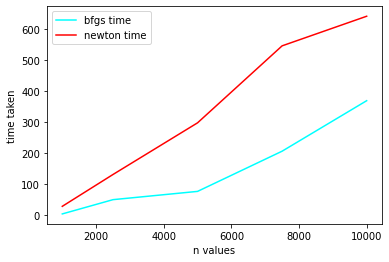

In [ ]:
import matplotlib.pyplot as plt

plt.plot(n_val , bfgs_time, color = "cyan")
plt.plot(n_val , new_time, color = "red")
plt.xlabel("n values")
plt.ylabel("time taken")
plt.legend(["bfgs time", "newton time"])
plt.show()

**Observations:** The graph shows that compared Newton's method, the BFGS method is more efficient in terms of time taken to reach the optimizer. We can also see that as the number of variables increase, the difference in time taken to reach the optimizer by Newton's method and BFGS method increases. \
Thus, we can say that the BFGS method is a more efficient method than the Newton's method.